In [26]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from vr2f.staticinfo import COLORS, CONFIG, PATHS


In [1]:
import multiprocessing as mp
mp.cpu_count()

144

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_data(subID, picks="eeg"):
    paths = PATHS()
    path_in = Path(paths.DATA_03_AR, "cleaneddata")
    fname = Path(path_in, f"{subID}-postAR-epo.fif")
    epos = mne.read_epochs(fname, verbose=False).pick(picks)
    times = epos.times
    info = epos.info

    return epos, times, info

In [4]:
# load data
paths = PATHS()
config = CONFIG()
colors = COLORS()

In [111]:
path_in = Path(paths.DATA_03_AR, "cleaneddata")
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]
sub_list_str = sorted(sub_list_str)
epos = []
evos = []
for sub in sub_list_str:
    ee = get_data(sub)
    epos.append(ee)

In [112]:
emotions = ["happy", "angry", "neutral", "surprised"]

evos = defaultdict(dict)
evos_ga = defaultdict(dict)
for vc in ["stereo", "mono", ""]:
    for emo in emotions:
        evos[emo] = []
        for sub in epos:
            evos[emo].append(sub[0][emo].average())
        evos_ga[emo] = mne.grand_average(evos[emo])

        if vc == "":
            continue
        evos[vc][emo] = []
        for sub in epos:
            evos[vc][emo].append(sub[0][vc + "/" + emo].average())
        evos_ga[vc][emo] = mne.grand_average(evos[vc][emo])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [113]:
# calc differences to neutral for  all emotions

evos_diff = defaultdict(dict)
evos_diff_ga = defaultdict(dict)
evos_diff_stereo_vs_mono = defaultdict(list)
for vc in ["stereo", "mono", ""]:
    for emo in emotions:
        evos_diff[emo] = []
        for sub in epos:
            evos_diff[emo].append(
                mne.combine_evoked([sub[0][emo].average(), sub[0]["neutral"].average()], weights=[1, -1])
            )
        evos_diff_ga[emo] = mne.grand_average(evos_diff[emo])

        if vc == "":
            continue
        evos_diff[vc][emo] = []
        for sub in epos:
            evos_diff[vc][emo].append(
                mne.combine_evoked(
                    [sub[0][vc + "/" + emo].average(), sub[0][vc + "/" + "neutral"].average()], weights=[1, -1]
                )
            )
        evos_diff_ga[vc][emo] = mne.grand_average(evos_diff[vc][emo])

for emo in emotions:
    for sub in epos:
        evos_diff_stereo_vs_mono[emo].append(
            mne.combine_evoked([sub[0]["mono/" + emo].average(), sub[0]["stereo/" + emo].average()], weights=[1, -1])
        )

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/tmp/ipykernel_20055/3495558950.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


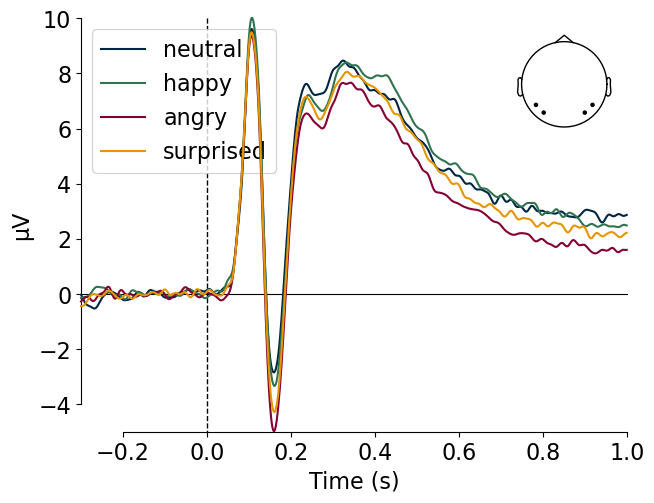

In [295]:
emotions = ["neutral", "happy", "angry", "surprised"]
cols = {c: colors.COLDICT[c] for c in emotions}

# ROIs and times inspired by Ziereis & Schacht (2023) https://doi.org/10.3758/s13415-023-01112-5

picks = dict()
picks["P1"] = ["O1", "O2", "Oz"]
picks["N170"] = ["P7", "P8", "PO7", "PO8"]
picks["EPN"] = ["P7", "PO7", "Pz", "Oz", "O1", "P8", "PO8", "O2"]
picks["LPC"] = ["Pz", "POz", "PO3", "PO4"]

erp_windows = dict()
erp_windows["P1"] = (0.08, 0.12)
erp_windows["N170"] = (0.13, 0.2)
erp_windows["EPN"] = (0.25, 0.3)
erp_windows["LPC"] = (0.4, 0.6)

cm = 1 / 2.54  # centimeters in inches
matplotlib.rcParams.update({"font.size": 16})

fig, ax = plt.subplots(1, 1, figsize=(16.5 * cm, 12.5 * cm))

p = mne.viz.plot_compare_evokeds(
    {emo: evos_ga[emo] for emo in emotions},
    picks=picks["N170"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-5, 10]),
    title="",
    colors=cols,
    show_sensors="upper right",
    axes=ax,
)
fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_emo_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [296]:
# Calc mean amplitudes:


erps = defaultdict()
df_erps = pd.DataFrame()
for vc in ["mono", "stereo"]:
  erps[vc] = defaultdict(dict)
  for erp in ["P1", "N170", "EPN", "LPC"]:
    erps[vc][erp] = defaultdict(list)
    for emo in emotions:
      erps[vc][erp][emo] = []
      for e, s_id in zip(evos[vc][emo], sub_list_str):
          e = e.copy()
          e.crop(*erp_windows[erp])
          e.pick(picks[erp])
          erps[vc][erp][emo].append(np.mean(e.data)*1e6)
    df = pd.DataFrame(erps[vc][erp])
    df["component"] = erp
    df["vc"] = vc
    df["sub_id"] = sub_list_str
    df_erps = pd.concat([df_erps, df], axis=0)

df_erps["component"] = pd.Categorical(df_erps["component"], categories=["P1", "N170", "EPN", "LPC"], ordered=True)


In [201]:
df_erps

,neutral,happy,angry,surprised,component,vc,sub_id
0,14.049700,15.656581,14.146622,13.649287,P1,mono,VR2FEM_S01
1,9.607718,9.699691,8.610560,7.507862,P1,mono,VR2FEM_S02
2,5.627941,5.798533,7.912222,8.126322,P1,mono,VR2FEM_S03
3,5.557451,9.090362,6.943612,6.149489,P1,mono,VR2FEM_S04
4,5.022668,5.071633,4.406031,5.155218,P1,mono,VR2FEM_S05
...,...,...,...,...,...,...,...
28,5.375696,6.182417,6.947937,6.028498,lateP1,stereo,VR2FEM_S30
29,3.192748,1.314637,-0.295340,1.684536,lateP1,stereo,VR2FEM_S31
30,6.101650,6.335677,4.856273,5.112287,lateP1,stereo,VR2FEM_S32
31,10.862298,9.932243,9.370348,7.924860,lateP1,stereo,VR2FEM_S33


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


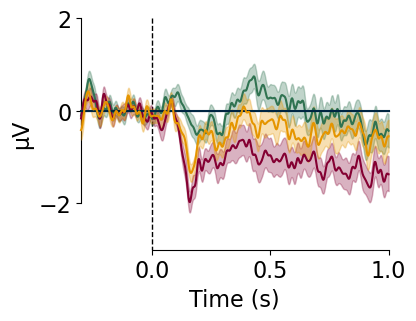

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

p = mne.viz.plot_compare_evokeds(
    {emo: evos_diff[emo] for emo in emotions},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={emo: colors.COLDICT[emo] for emo in emotions},
    legend=False,
    ci=0.68,
    axes=ax,
)
fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_emo-vs-neutral_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

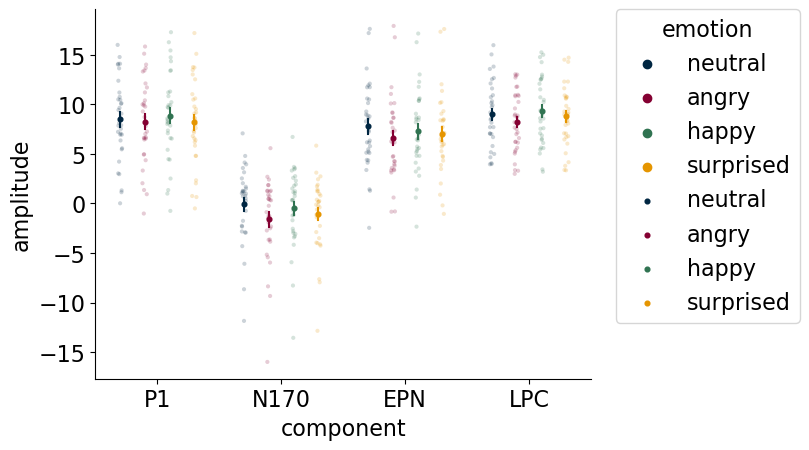

In [289]:
df_plt = (df_erps
            .melt(id_vars=["component", "vc", "sub_id"], value_vars=emotions, var_name="emotion", value_name="amplitude")
            .groupby(["component", "sub_id", "emotion"])
            .mean()
            .sort_values(by=["component"])
            .reset_index()
)

df_plt["emotion"] = pd.Categorical(df_plt["emotion"], categories=["neutral", "angry", "happy", "surprised"],
                                   ordered=True)
df_plt.sort_values(by=["emotion"])


o = sns.stripplot(data=df_plt, x="component", y="amplitude", hue="emotion", dodge=True,
                  palette=colors.COLDICT, size=3, jitter=0.075,
                  alpha=0.2)
o = sns.pointplot(
    data=df_plt.reset_index(),
    x="component",
    y="amplitude",
    hue="emotion",
    errorbar="se",
    dodge=0.6,
    palette=colors.COLDICT,
    linestyles='None',
    markers="o",
    scale=0.5,
    errwidth=1.5,
    )

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

combining channels using "mean"
combining channels using "mean"


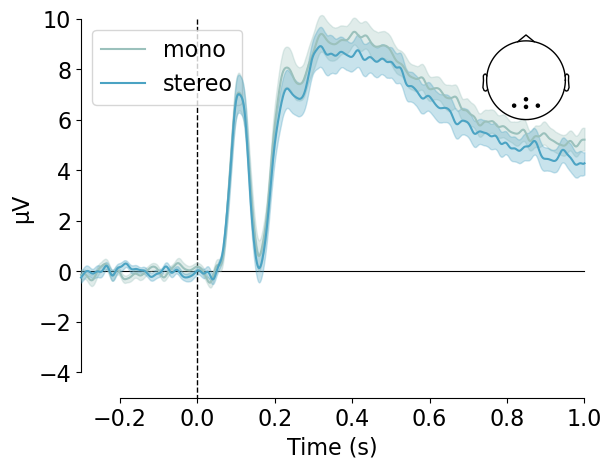

/tmp/ipykernel_20055/2120617116.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [169]:
emo_showcase = "angry"

fig, ax = plt.subplots(1, 1, figsize=(16.5 * cm, 12.5 * cm))

p = mne.viz.plot_compare_evokeds(
    {"mono": evos["mono"][emo_showcase], "stereo": evos["stereo"][emo_showcase]},
    picks=picks["LPC"],
    show=True,
    combine="mean",
    ylim=dict(eeg=[-5, 10]),
    title="",
    colors={vc: colors.COLDICT[vc] for vc in ["mono", "stereo"]},
    ci=0.68,
    show_sensors="upper right",
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_angry_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

combining channels using "mean"
combining channels using "mean"


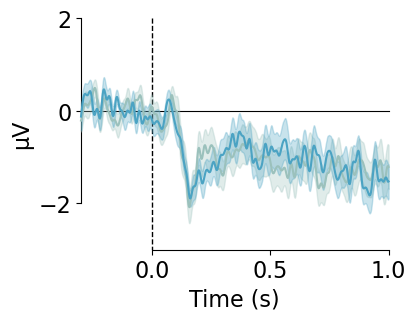

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

p = mne.viz.plot_compare_evokeds(
    {"mono": evos_diff["mono"][emo_showcase], "stereo": evos_diff["stereo"][emo_showcase]},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={vc: colors.COLDICT[vc] for vc in ["mono", "stereo"]},
    legend=False,
    ci=0.68,
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_angry-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

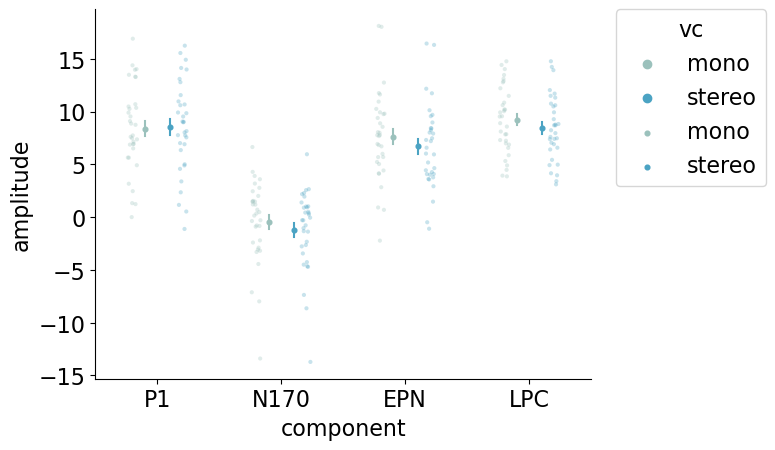

In [291]:


df_plt = (df_erps
            .melt(id_vars=["component", "vc", "sub_id"], value_vars=emotions, var_name="emotion", value_name="amplitude")
            .groupby(["vc", "sub_id", "component"])
            .mean()
            .sort_values(by=["component"])
            .reset_index()
)

o = sns.stripplot(data=df_plt, x="component", y="amplitude", hue="vc", dodge=True,
                  palette=colors.COLDICT, size=3, jitter=0.075,
                  alpha=0.3)
o = sns.pointplot(
    data=df_plt.reset_index(),
    x="component",
    y="amplitude",
    hue="vc",
    errorbar="se",
    dodge=0.2,
    palette=colors.COLDICT,
    linestyles='None',
    markers="o",
    scale=0.5,
    errwidth=1.5,
    )
sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

In [298]:

df_aov = (df_erps
            .melt(id_vars=["component", "vc", "sub_id"], value_vars=emotions, var_name="emotion", value_name="amplitude")
)

for erp_win in erp_windows:  # noqa: B007
  print(f"\n\nANOVA for {erp_win}")
  print(AnovaRM(df_aov.query("component == @erp_win"),
                depvar = "amplitude",
                subject = "sub_id",
                within = ["vc", "emotion"]).fit())

  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_aov
                  .query("component == @erp_win")
                  .groupby(["sub_id", "emotion"])
                  .agg({"amplitude": "mean", "emotion": "first"})
  )

  pairwise_comps = [(emotions[i], emotions[j]) for i in range(len(emotions))
                                               for j in range(len(emotions)) if i < j]

  posthoc_results = {}
  for e1, e2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("emotion == @e1")["amplitude"],
                              df_posthoc.query("emotion == @e2")["amplitude"])
    posthoc_results[f"{e1} vs {e2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()]
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")

  # Define the column widths
  col1_width = 20
  col2_width = 10

  # Print the header
  header = f"{'Comparison':<{col1_width}} {'p-value (adj)':<{col2_width}}"
  print(header)
  print('-' * (col1_width + col2_width ))

  for contrast, p in zip(posthoc_results.keys(), p_adj, strict=True):
    print(f"{contrast:<{col1_width}} {p:<{col2_width}.3f}")



ANOVA for P1
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
vc          1.6952 1.0000 32.0000 0.2022
emotion     6.8542 3.0000 96.0000 0.0003
vc:emotion  0.7517 3.0000 96.0000 0.5240

Comparison           p-value (adj)
------------------------------
neutral vs happy     0.179     
neutral vs angry     0.607     
neutral vs surprised 0.456     
happy vs angry       0.013     
happy vs surprised   0.005     
angry vs surprised   1.000     


ANOVA for N170
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
vc         22.9645 1.0000 32.0000 0.0000
emotion    30.1366 3.0000 96.0000 0.0000
vc:emotion  0.2207 3.0000 96.0000 0.8818

Comparison           p-value (adj)
------------------------------
neutral vs happy     0.129     
neutral vs angry     0.000     
neutral vs surprised 0.000     
happy vs angry       0.000     
happy vs surprised   0.006     
angry vs surprised   0.029

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


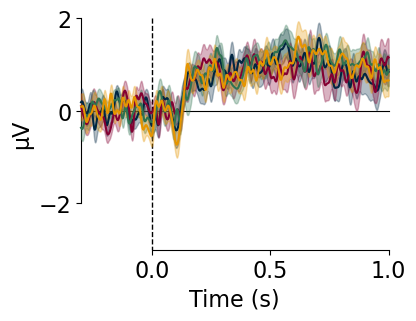

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

emos = ["neutral", "angry", "happy", "surprised"]

p = mne.viz.plot_compare_evokeds(
    {emo: evos_diff_stereo_vs_mono[emo] for emo in emos},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={emo: colors.COLDICT[emo] for emo in emos},
    legend=False,
    ci=0.68,
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
# fig.savefig(
#     Path(paths.FIGURES, f"erp_angry-vs-neutral_mono-vs-stereo.pdf"),
#     transparent=True,  # bbox_inches="tight"
# )

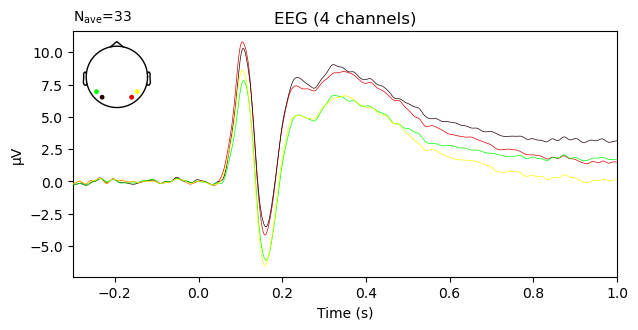

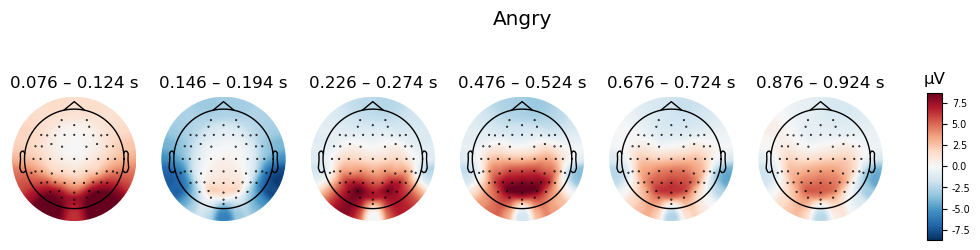

No projector specified for this dataset. Please consider the method self.add_proj.


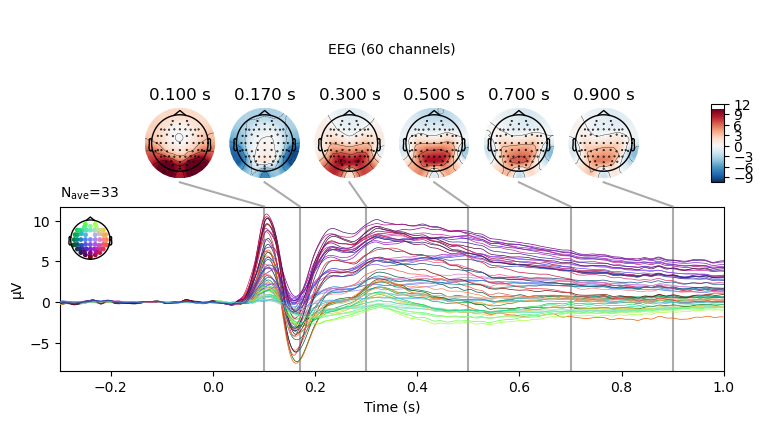

In [9]:
emo_target = "angry"
p = evos_ga[emo_target].plot(spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"])
P = evos_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_ga[emo_target].plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])

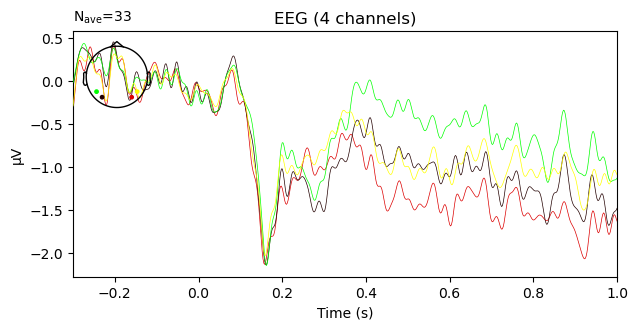

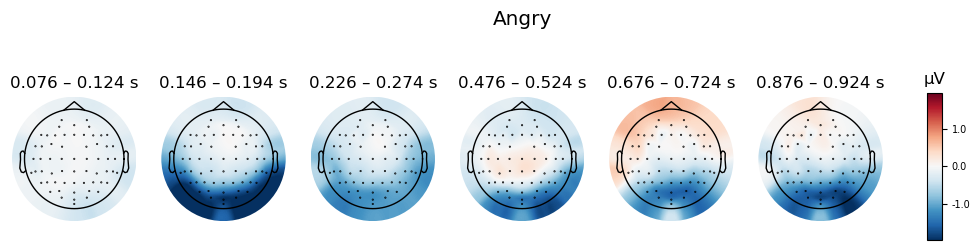

No projector specified for this dataset. Please consider the method self.add_proj.


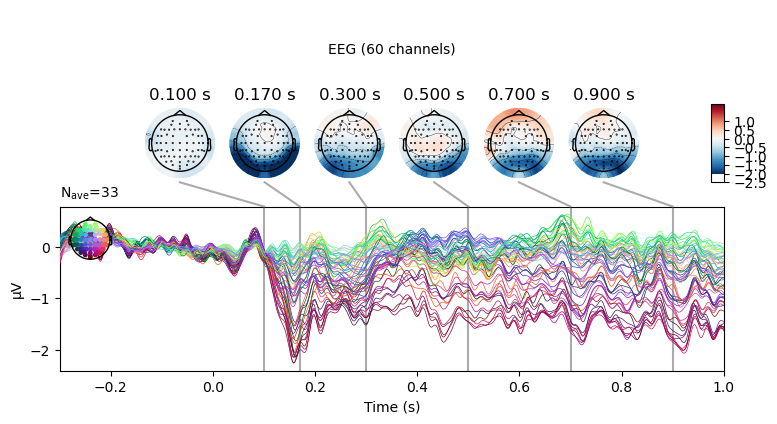

In [12]:
P = evos_diff_ga[emo_target].plot(spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"])
p = evos_diff_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_diff_ga[emo_target].plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])

In [15]:
picks = ["Oz", "POz", "PO3", "PO4", "O1", "O2", "PO7", "PO8"]
# mne.viz.plot_compare_evokeds([evos["angry"], evos["neutral"]], show_sensors="upper right", combine='mean')

diff = mne.combine_evoked([evos["angry"], evos["neutral"]], weights=[1, -1])

AttributeError: 'list' object has no attribute 'nave'

In [34]:
view_conds = ["mono", "stereo"]
for vc in view_conds:
    evos[vc] = []
    for sub in epos:
        evos[vc].append(sub[0][vc][emo_showcase].average())

NameError: name 'emo_showcase' is not defined

In [33]:
evos_vc = {vc: evos[vc] for vc in view_conds}
mne.viz.plot_compare_evokeds(evos_vc, show_sensors="upper right", combine="mean", picks=picks["EPN"], ci=True)

NameError: name 'view_conds' is not defined

In [93]:
e_m = mne.combine_evoked(evos_vc["mono"], weights="equal")
e_s = mne.combine_evoked(evos_vc["stereo"], weights="equal")

No projector specified for this dataset. Please consider the method self.add_proj.


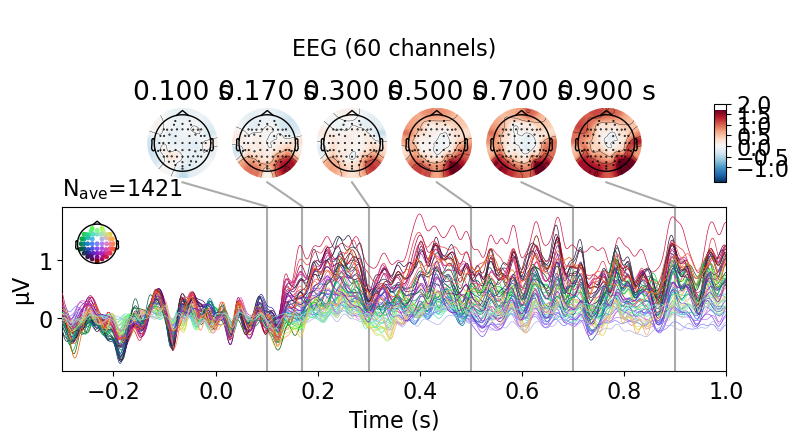

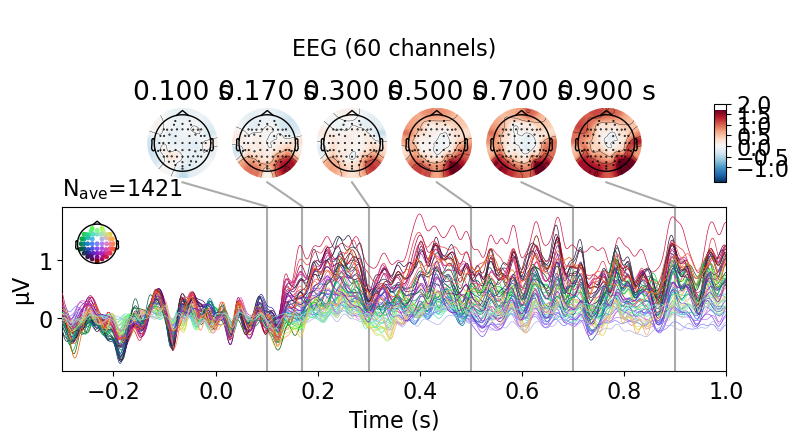

In [95]:
diff_vc = mne.combine_evoked([e_m, e_s], weights=[1, -1])
diff_vc.plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])